In [ ]:
#%%
from scipy.signal import medfilt
from spectral import imshow, view_cube
import spectral.io.envi as envi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from PIL import Image
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from skimage import measure
from sklearn.utils import resample
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
from scipy.spatial import distance
from pathlib                 import Path
import glob


plt.close('all')
path = glob.glob(r'./Train_Data/HSI_Data/*')
filename=path[0][path[0].rfind('\\')+1:]
print(filename)
img_rgb = Image.open(os.path.join(path[0], filename+'.png')).convert('RGB')
img_rgb_ar = np.array(img_rgb)
view_rgb = imshow(img_rgb_ar)
hsi_ref = envi.open(os.path.join(path[0], filename+'.hdr'),\
                      os.path.join(path[0], filename+'.dat'))
hsi_np = hsi_ref.asarray()
Mask = np.load('./Train_Data/Valid_Mask/'+filename+'.npy')

In [ ]:
#%% filtering the peanut spectra with 1x5 convolutional filter
row,col = np.where(Mask==1)
hsi_p=hsi_np[row,col]
hsi_filtered=np.zeros((len(hsi_p),299))

rand_np = np.copy(hsi_np)
for i in range(len(hsi_p)):
    rand_np[row[i],col[i]] = medfilt(hsi_np[row[i],col[i]],5)

In [ ]:
#%% Normalize the peanut spectra
for i in range(len(row)):
    rand_np[row[i],col[i]]=(rand_np[row[i],col[i]]-min(rand_np[row[i],col[i]]))/(max(rand_np[row[i],col[i]])-min(rand_np[row[i],col[i]]))


In [ ]:
all_peanut_pixels=rand_np[row,col]
all_peanut_pixels.T.shape

In [ ]:
#%%
from Model import *
import matplotlib.pyplot as plt


# def main():

# load the data from the pickle file

valid_mask=Mask.astype(bool)
# trim the noisy bands
hsi_image = rand_np[:,:,50:-50]
x_ax=np.linspace(402,998,299)
x_ax=x_ax[50:-50]
img_shape = hsi_image.shape
n_r, n_c, n_b = hsi_image.shape

# load the wavelength information

# reshape the data because SPICE takes an MxN array, not a full HSI cube
hsi_image = np.reshape(hsi_image, (img_shape[0]*img_shape[1], img_shape[2]))
valid_array = np.reshape(valid_mask, (img_shape[0]*img_shape[1],))
# take the hsi data at the "valid" points
M = hsi_image[valid_array, :]

# since analyzing the image will take a long time, we will down sample the data for the sake of this demo
input_data = M.T.astype(float)
ds_data = input_data[:, ::20] 

# get the default parameters from the SPICE.py file
params = SPICEParameters()
params.qp_solver = 'QPP'
params.gamma=10
params.u=0.1
# run the spice algorithm on the down sampled data
[endmembers, ds_proportions] = SPICE(ds_data, params)

# prompt the user to see if they would like to graph the output
# if input('Would you like to plot the output? (Y/n): ') == 'n':
#     return

# plot the wavelength versus the reflectance
n_em = endmembers.shape[1]
plt.plot(x_ax, endmembers)
plt.xlabel('wavelength (nm)')
plt.ylabel('reflectance')
plt.legend([str(i + 1) for i in range(n_em)])
plt.title('SPICE Endmembers')

In [ ]:
#%%

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 28 10:58:03 2020

@author: weihuang
"""
# load the data from the pickle file

valid_mask=Mask.astype(bool)
# trim the noisy bands
hsi_image = rand_np[:,:,50:-50]
x_ax=np.linspace(402,998,299)
x_ax=x_ax[50:-50]
img_shape = hsi_image.shape
n_r, n_c, n_b = hsi_image.shape

# load the wavelength information

# reshape the data because SPICE takes an MxN array, not a full HSI cube
hsi_image = np.reshape(hsi_image, (img_shape[0]*img_shape[1], img_shape[2]))
valid_array = np.reshape(valid_mask, (img_shape[0]*img_shape[1],))
# take the hsi data at the "valid" points
M = hsi_image[valid_array, :]

# since analyzing the image will take a long time, we will down sample the data for the sake of this demo
input_data = M.T.astype(float)
ds_data = input_data[:, ::20]

# unmix the data using the non-downsampled array and the endmembers that SPICE discovered


if params.qp_solver == 'cvxopt':
    P = unmix_cvxopt(input_data, endmembers)
else:
    scaler = input_data.max()
    P = unmix_qpp(input_data/scaler,endmembers/scaler)

# re-ravel abundance maps
P_imgs = []
for i in range(n_em):
    map_lin = np.zeros((n_r * n_c,))
    map_lin[valid_array] = P[:, i]
    P_imgs.append(np.reshape(map_lin, (n_r, n_c)))

# display abundance maps in the form of a subplot

fig, axes = plt.subplots(2, int(n_em/2) + 1, squeeze=True,figsize=(30,8))

for i in range(n_em):
    im = axes.flat[i].imshow(P_imgs[i], vmin=0, vmax=1)
    axes.flat[i].set_title('SPICE Abundance Map %d' % (i + 1))

# add the original RGB image to the subplot
im = axes.flat[n_em].imshow(img_rgb_ar)
axes.flat[n_em].set_title(filename)
fig.colorbar(im, ax=axes.ravel().tolist())

# delete any empty subplots
if (n_em % 2 == 0):
    fig.delaxes(axes.flatten()[(2*(int(n_em/2)+1)) -1])
# plt.savefig(filename+'.jpg')
plt.show()
    

In [ ]:
p=np.copy(P_imgs[1])
p[p>=0.5]=1
p[p<0.5]=0
plt.imshow(p)

In [ ]:
r_p,c_p=np.where(p==1)

In [ ]:
pb=rand_np[r_p,c_p]

In [ ]:
np.shape(pb)

In [ ]:
positive_bags=np.array_split(pb[0:2380],60)

In [ ]:
plt.plot(positive_bags[0][0,:])

In [ ]:
neg=P_imgs[3]+P_imgs[2]+P_imgs[0]
neg[neg>=0.5]=1
neg[neg<0.5]=0
plt.imshow(neg)
r_n,c_n=np.where(neg==1)

In [ ]:
nb=rand_np[r_n,c_n]

In [ ]:
nb=np.copy(rand_np)
nb=np.ma.array(nb, mask=False)
nb.mask[r_p,c_p]=True
nb.compressed()

In [ ]:
nb.shape

In [ ]:
len(r_n)

In [ ]:
negative_bags=np.array_split(nb[0:29932],60)
negative_bags_test=np.array_split(nb[29932:-1],60)

In [ ]:
bags=np.array([])
bags=np.append(bags,np.asarray(positive_bags))
bags=np.append(bags,np.asarray(negative_bags))
[np.asarray(positive_bags), np.asarray(negative_bags)]

In [ ]:
np.shape(bags)

In [ ]:
plt.plot(negative_bags[0][0,:])

In [ ]:
labels=np.zeros((1,120))
labels[0,0:60]=1

In [ ]:
len(r_n)

In [ ]:
for i in range(len(r_n)):
    plt.plot(rand_np[r_n[i],c_n[i],:])

In [ ]:
labels_test=Mask
labels_test[r_n,c_n]=0
labels_test=np.reshape(labels_test, (labels_test.shape[0]*labels_test.shape[1],))
labels_test.shape

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from miace.detectors import ace_det, smf_det
from miace.mi_target import mi_target

results = {'smf': {}, 'ace': {}}

parameters = {
    "global_background_flag": False,
    "pos_label": 1,
    "neg_label": 0,
    "max_iter": 100,
    "init_type": 1,
	"init_k": 1000
}

example_data = np.load('datasets/simple_example_data.npz')

# to accomodate bags of difference sizes
bag_list = [example_data['data_bags'][i] for i in range(example_data['data_bags'].shape[0])]

#to test whether the methods work on different sizes. combining a few bags together to create uneven bags
bag_list[0] = np.vstack((bag_list[0], bag_list[1]))
bag_list.pop(1)
labels = np.delete(example_data['labels'], 1, 1)

# SMF init1
print('------------ Spectral Matched Filter -------------')
parameters['method_flag'] = False
parameters['sample_por'] = 1
labels=np.zeros((1,120))
labels[0,0:60]=1
# smf_opt_target, _, b_mu, sig_inv_half, _ = mi_target(
#     example_data['data_bags'], example_data['labels'], parameters)

smf_opt_target, _, b_mu, sig_inv_half, _ = mi_target(np.asarray(bags), labels, parameters)

print('Detecting SMF...')
# smf_data, _, _ = smf_det(example_data['x_test'], smf_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
smf_data, _, _ = smf_det(np.reshape(rand_np,(rand_np.shape[0]*rand_np.shape[1],rand_np.shape[2])).T, smf_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
# ACE init 1
print('------------ Adaptive Cosine Estimator -------------')
parameters['method_flag'] = True
parameters['sample_por'] = 1

# ace_opt_target, _, b_mu, sig_inv_half, _ = mi_target(
#     example_data['data_bags'], example_data['labels'], parameters)

ace_opt_target, _, b_mu, sig_inv_half, _ = mi_target(np.asarray(bags), labels, parameters)

print('Detecting ACE...')
# ace_data, _, _ = ace_det(example_data['x_test'], ace_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
ace_data, _, _ = ace_det(np.reshape(rand_np,(rand_np.shape[0]*rand_np.shape[1],rand_np.shape[2])).T, ace_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))

print('\nPlotting Target Concept and ROC Curve...')

# Get false and true positive rate
# labels_point_test = example_data['labels_point_test']
labels_point_test = labels_test

smf_fpr, smf_tpr, smf_threshold = roc_curve(labels_point_test, smf_data, pos_label=1)
ace_fpr, ace_tpr, ace_threshold = roc_curve(labels_point_test, ace_data, pos_label=1)


f, (ax1, ax2) = plt.subplots(2, sharex=False, sharey=False)

# Target Concept
ax1.plot(np.linspace(400,1000,len(smf_opt_target)),smf_opt_target, 'b', label='SMF Target Concept')
ax1.plot(np.linspace(400,1000,len(ace_opt_target)),ace_opt_target, 'r', label='ACE Target Concept')
ax1.legend(loc='lower right')
ax1.set_xlabel('Band Number')

# ROC
ax2.plot(smf_fpr, smf_tpr, 'b', label='SMF ROC')
ax2.plot(ace_fpr, ace_tpr, 'r', label='ACE ROC')
ax2.plot([0, 1], [0, 1], 'r--')
ax2.legend(loc='lower right')
ax2.set_xlabel('Probability of False Alarm')
ax2.set_ylabel('Probability of Detection')

ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()


C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


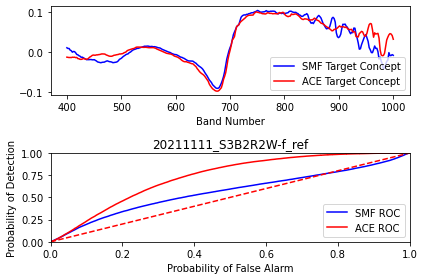

In [33]:
# plt.close('all')
# path = glob.glob(r'./Train_Data/HSI_Data/*')
# filename=path[0][path[0].rfind('\\')+1:]
# print(filename)
# img_rgb = Image.open(os.path.join(path[0], filename+'.png')).convert('RGB')
# img_rgb_ar = np.array(img_rgb)
# view_rgb = imshow(img_rgb_ar)
# hsi_ref = envi.open(os.path.join(path[0], filename+'.hdr'),\
#                       os.path.join(path[0], filename+'.dat'))
# hsi_np = hsi_ref.asarray()
# Mask = np.load('./Train_Data/Valid_Mask/'+filename+'.npy')

hsi_ref = envi.open(r'U:\AT\Data\lab_HSI\Greenhouse_202111\Reflectance folders\20211111_S3B2R2W-f_ref\20211111_S3B2R2W-f_ref.hdr',\
                      r'U:\AT\Data\lab_HSI\Greenhouse_202111\Reflectance folders\20211111_S3B2R2W-f_ref\20211111_S3B2R2W-f_ref.dat')
hsi_np = hsi_ref.asarray()
Mask = np.load(r'U:\AT\Data\lab_HSI\Greenhouse_202111\Masks\20211111_S3B2R2W-f_ref.npy')
#%% filtering the peanut spectra with 1x5 convolutional filter
row,col = np.where(Mask==1)
hsi_p=hsi_np[row,col]
hsi_filtered=np.zeros((len(hsi_p),299))

rand_np = np.copy(hsi_np)
for i in range(len(hsi_p)):
    rand_np[row[i],col[i]] = medfilt(hsi_np[row[i],col[i]],5)
#%% Normalize the peanut spectra
for i in range(len(row)):
    rand_np[row[i],col[i]]=(rand_np[row[i],col[i]]-min(rand_np[row[i],col[i]]))/(max(rand_np[row[i],col[i]])-min(rand_np[row[i],col[i]]))
labels_test=Mask
labels_test[r_n,c_n]=0
labels_test=np.reshape(labels_test, (labels_test.shape[0]*labels_test.shape[1],))
labels_test.shape

smf_data, _, _ = smf_det(np.reshape(rand_np,(rand_np.shape[0]*rand_np.shape[1],rand_np.shape[2])).T, smf_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
ace_data, _, _ = ace_det(np.reshape(rand_np,(rand_np.shape[0]*rand_np.shape[1],rand_np.shape[2])).T, ace_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
labels_point_test = labels_test

smf_fpr, smf_tpr, smf_threshold = roc_curve(labels_point_test, smf_data, pos_label=1)
ace_fpr, ace_tpr, ace_threshold = roc_curve(labels_point_test, ace_data, pos_label=1)


f, (ax1, ax2) = plt.subplots(2, sharex=False, sharey=False)

# Target Concept
ax1.plot(np.linspace(400,1000,len(smf_opt_target)),smf_opt_target, 'b', label='SMF Target Concept')
ax1.plot(np.linspace(400,1000,len(ace_opt_target)),ace_opt_target, 'r', label='ACE Target Concept')
ax1.legend(loc='lower right')
ax1.set_xlabel('Band Number')

# ROC
ax2.plot(smf_fpr, smf_tpr, 'b', label='SMF ROC')
ax2.plot(ace_fpr, ace_tpr, 'r', label='ACE ROC')
ax2.plot([0, 1], [0, 1], 'r--')
ax2.legend(loc='lower right')
ax2.set_xlabel('Probability of False Alarm')
ax2.set_ylabel('Probability of Detection')
ax2.set_title('20211111_S3B2R2W-f_ref')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()